,TOTAL_ADD_CS
DATA,
2003-04-01,805
2003-04-21,517
2003-04-24,20
2003-05-06,8
2003-05-12,268
...,...
2020-02-24,4
2020-02-25,4
2020-03-03,1


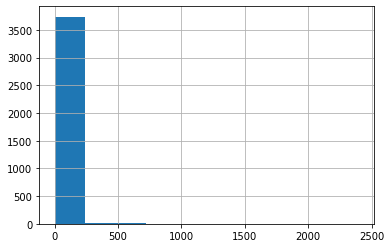

'Results of Dickey-Fuller Test:'

Test Statistic                  -42.940346
p-value                           0.000000
Lags Used                         1.000000
Number of Observations Used    3777.000000
Critical Value (1%)              -3.432083
Critical Value (5%)              -2.862306
Critical Value (10%)             -2.567178
dtype: float64

'Result adf : The series is  stationary'

'Reject Ho - Time Series is Stationary'

'Results of KPSS Test:'

'KPSS Statistic: 0.09860594259319189'

'p-value: 0.1'

'num lags: 13'

'Critial Values:'

'   10% : 0.347'

'   5% : 0.463'

'   2.5% : 0.574'

'   1% : 0.739'

'Result kpss_test: The series is  stationary'

'Observations: 944 Treino: 755 Teste: 189'

ValueError: min() arg is an empty sequence

In [9]:
import itertools
import pyodbc
from IPython.core.display import display
from matplotlib import pyplot
from pmdarima import plot_acf, plot_pacf
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import kpss
from Query import Query
from configuration import Configuration
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt3
import matplotlib.pyplot as pltForecast
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import seaborn as sns
from sklearn.metrics import  mean_absolute_error
import numpy as np
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



#Referencias de publicações sobre a utilização de bibliotecas python para series temporais.
#https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3
#https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/


def melhor_aic(data):
    # Grid Search Best AIC
    p = d = q = range(0,8) # p, d, and q can be either 0, 1, or 2
    pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q
    combs = {} # stores aic and order pairs
    aics = [] # stores aics
    # Grid Search continued
    for combination in pdq:
        try:
            model = ARIMA(data, order=combination) # create all possible models
            model = model.fit()
            combs.update({model.aic : combination   }) # store combinations
            aics.append(model.aic)
        except:
            continue
    best_aic = min(aics)
    display("Melhor AIC Treino : {0} {1}".format(best_aic, combs[best_aic]))
    return combs[best_aic]

def testar_estacionaridade(timeseries):
    figsize=(22,8)
    lags_plots = 1
    wind = 3
    timeseries.hist()
    pyplot.show()

    #Determing rolling statistics
    #rolmean = pd.Series(timeseries).rolling(window=wind).mean()
    #rolstd = pd.Series(timeseries).rolling(window=wind).std()
    #Plot rolling statistics:
    #orig = plt.plot(timeseries, color='blue',label='Original')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #plt.legend(loc='best')
    #plt.title('Rolling Mean & Standard Deviation')
    #plt.show(block=False)

    #Perform Dickey-Fuller & KPSS test:
    adf_test(timeseries)
    kpss_test(timeseries)
    #y = pd.Series(timeseries)
    #fig = plt.figure()
    #ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    #ax2 = plt.subplot2grid((3, 3), (1, 0))
    #ax3 = plt.subplot2grid((3, 3), (1, 1))
    #ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)
    #y.plot(ax=ax1, figsize=figsize, color='teal')
    #ax1.set_title('Série de code smell')
    #plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal')
    #plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal')
    #sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    #ax4.set_title('Distribuição dos code smell')
    #plt.tight_layout()

def adf_test(series):
     #Perform Dickey-Fuller test:
    display('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    display(dfoutput)
    #O valor p é maior do que o nível de significância 0,05,
    # por isso não é estacionário e diferenciamento é como tal necessário,
    # ou seja. d > 0.
    display(f'Result adf : The series is {"not " if dftest[1] > 0.05 else ""} stationary')
    if dftest[0] > dftest[4]["5%"]:
        display ("Failed to Reject Ho - Time Series is Non-Stationary")
    else:
        display ("Reject Ho - Time Series is Stationary")



def kpss_test(series):
    statistic, p_value, n_lags, critical_values = kpss(series, regression='c', nlags="auto")
    # Format Output
    display('Results of KPSS Test:')
    display(f'KPSS Statistic: {statistic}')
    display(f'p-value: {p_value}')
    display(f'num lags: {n_lags}')
    display('Critial Values:')
    for key, value in critical_values.items():
        display(f'   {key} : {value}')
    display(f'Result kpss_test: The series is {"not " if p_value < 0.05 else ""} stationary')

def verificar_erro(orig, prev, nome_col='', nome_indice=''):
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    display(serie)

    #accuracy_score(orig, prev)



def recuperar_dados_train_test(df,percentual):
    registros = len(df)
    qtdTreino = 0
    if percentual == 100:
        qtdTreino = registros
    elif percentual > 0 :
        qtdTreino = int( registros / 100 * percentual)
    elif percentual == 0 :
        qtdTreino = int( registros / 100 * 80)

    qtdTest = registros - qtdTreino
    treino = df.iloc[:qtdTreino]
    teste = df.iloc[qtdTreino:registros]
    display('Observations: %d' % registros + ' Treino: %d' % qtdTreino + ' Teste: %d' % qtdTest)
    return  treino,teste

def recuperar_dataset():
    desenvolvedor =  Configuration.getConfigValue('developer_id')
    query = Query.getQuery('query_5_1')
    ##query = query.replace('{desenvolvedor}',desenvolvedor)
    conn = pyodbc.connect(Configuration.getConfigValue('database_connection'))
    query_result = pd.read_sql_query(query,conn)
    df = pd.DataFrame(query_result)
    df['TOTAL_ADD_CS'].astype('float64')
    df['DATA'] = pd.to_datetime(df['DATA'], dayfirst=True)
    df.sort_values('DATA', inplace=True)
    df.set_index('DATA', inplace=True)
    df.head()
    return df

def exibir_grafico_dados_train_test(treino,teste):
    plt.figure(figsize=(18,5))
    plt.title('Quantidade de code smell do desenvolvedor por mês')
    plt.plot(treino, color='teal')
    plt.plot(teste, color='orangered')
    plt.legend(['Treino','Teste'])
    plt.xlabel('DATA')
    plt.ylabel('TOTAL_ADD_CS')
    plt.show()

def exibir_grafico_previsao(original,teste):
    plt.clf()
    plt.figure(figsize=(18,5))
    plt.title('Quantidade de code smell do desenvolvedor por mês')
    plt.plot(original, color='orangered')
    plt.plot(teste, color='blue')
    plt.legend(['Teste','Previsao'])
    plt.xlabel('DATA')
    plt.ylabel('TOTAL_ADD_CS')
    plt.show()

def forecast(best_aic,train,test,full):
    elements = len(test)
    _train = len(train)
    _test = len(test)

    # Build Model
    model = ARIMA(train, order=best_aic)
    model_fit = model.fit(disp=-1)

    # Forecast
    #fc, se, conf = modelo.forecast(elements, alpha=0.05)  # 95% conf
    fc, se, conf = model_fit.forecast(elements,alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
    plt.title('Forecast x Atual')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    # Plot residual errors
    #residuals = pd.DataFrame(model_fit.resid)
    #fig, ax = plt2.subplots(1,2)
    #residuals.plot(title="Residuals", ax=ax[0])
    #residuals.plot(kind='kde', title='Density', ax=ax[1])
    #plt2.show()

    # Actual vs Fitted
    model_full = ARIMA(full, order=best_aic)
    model_fit_full = model_full.fit(disp=-1)
    model_fit_full.plot_predict(dynamic=False)

    return fc_series



def main():
    # load dataset
    dados = recuperar_dataset()
    display(dados)
    if len(dados) == 0:
        display("Não há dados para analisar")
    else:
        #check if data train is stationary
        testar_estacionaridade(dados['TOTAL_ADD_CS'])

        #dados aleatoria para treinar o modelo
        quantidade_total = len(dados)
        quantidade_fold =  int(quantidade_total / 4)
        best_aic = {}
        aics = []
        treino  = []
        teste  = []

        for i in range(1,4):
            df  = dados.head(quantidade_fold*i)
            #split into train and test sets
            treino, teste  = recuperar_dados_train_test(df,0)
            #verify best aic
            best_aic =  melhor_aic(treino)
            aics.append(best_aic)

        display(aics)
        best_aic = min(aics)
        display("AIC Selcionado : {0} ".format(best_aic))

        #show chart line train & test (OPCIONAL)
        #exibir_grafico_dados_train_test(treino, teste)

        # Train & Forecast
        fc_series   = forecast(best_aic,treino,teste,dados)

        #Gerando grafico previsao
        exibir_grafico_previsao(teste["TOTAL_ADD_CS"],fc_series)

        #Exibindo os erros
        verificar_erro(teste["INDICE_ESFORCO"],fc_series)

        #Exibindo os dados de origem
        display(dados)


main()